# Using gGN on Python

This notebook shows you how to load gGN on Python to learn node Gaussian embeddings from scratch.

## Preamble

In [1]:
#@title Install gGN
url = "git+https://github.com/blindcosmos/ggn.git"

# to avoid dependency conflicts on colab
!pip uninstall -y imgaug > /dev/null 
!pip uninstall -y albumentations > /dev/null

!pip install -U {url} > /dev/null

  Running command git clone -q https://github.com/blindcosmos/ggn.git /tmp/pip-req-build-ck0oz7sr


In [2]:
#@title Import libraries
from ggn.models import LowRankEmbedder
from ggn.utils import MyCollator, fit

import numpy as np
import scipy.sparse
import torch

import matplotlib.pyplot as plt

## Input graph

Since gGO uses the shortest path lengths from a graph, here a pre-built matrix with such lengths is downloaded to be used for node learning.

In [3]:
#@title Download the pre-built matrix of shortest path lengths
sp_fin = 'toy.npz'
graph_url = f"https://raw.githubusercontent.com/blindcosmos/ggn/main/ggn/{sp_fin}"

!wget -q {graph_url}

## Learn Gaussian embeddings

In [4]:
# settings
spmat    = scipy.sparse.load_npz(sp_fin) # load sparse matrix
batch_sz = 12                            # batch size
dim      = 2                             # embedding dimension
rank     = 2                             # rank of embeddings
cuda     = 0                             # 0/no, 1/yes
nepochs  = 100                           # number of epochs
n_nodes  = spmat.shape[0]

# create dataloader using sparse matrix
ds = torch.utils.data.DataLoader(
  [torch.LongTensor([i]) for i in range(n_nodes)],
  batch_size=batch_sz,
  collate_fn=MyCollator(spmat, cuda)
)

# instantiate an embedder
embedder = LowRankEmbedder(n_nodes, dim=dim, rank=rank)
if cuda:
  embedder = embedder.cuda()

# learn embeddings
losses, _ = fit(embedder, ds, epochs=nepochs)

# get learned embeddings
means = embedder.mean # means
diags = embedder.diag # diagonals
covms = embedder.covm # low-rank factors

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.7/dist-packages/ggn/distances.py:119: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  A = torch.triangular_solve(qWt_qDinv, qC_tril, upper=False)[0] # (N, K, d)


---Epoch 0: Loss 7.1653 0.30 sec ---
---Epoch 5: Loss 7.0190 0.01 sec ---
---Epoch 10: Loss 6.8783 0.01 sec ---
---Epoch 15: Loss 6.7432 0.01 sec ---
---Epoch 20: Loss 6.6139 0.01 sec ---
---Epoch 25: Loss 6.4900 0.00 sec ---
---Epoch 30: Loss 6.3714 0.01 sec ---
---Epoch 35: Loss 6.2577 0.00 sec ---
---Epoch 40: Loss 6.1488 0.00 sec ---
---Epoch 45: Loss 6.0442 0.01 sec ---
---Epoch 50: Loss 5.9438 0.00 sec ---
---Epoch 55: Loss 5.8472 0.00 sec ---
---Epoch 60: Loss 5.7542 0.00 sec ---
---Epoch 65: Loss 5.6645 0.00 sec ---
---Epoch 70: Loss 5.5779 0.01 sec ---
---Epoch 75: Loss 5.4942 0.01 sec ---
---Epoch 80: Loss 5.4132 0.00 sec ---
---Epoch 85: Loss 5.3347 0.00 sec ---
---Epoch 90: Loss 5.2585 0.01 sec ---
---Epoch 95: Loss 5.1845 0.00 sec ---


## Visualize loss values

The lower the loss, the better the embeddings are capturing graph features.

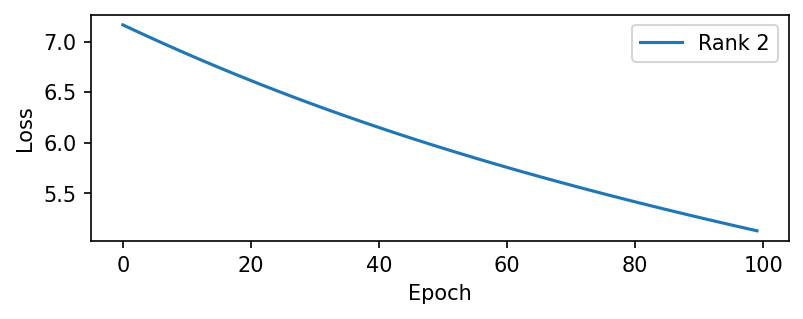

In [5]:
#@title Plot loss values
fig, axs = plt.subplots(figsize=(6,2), dpi=150)

axs.plot(losses,
         color='tab:blue',
         label=f'Rank 2')

axs.set_xlabel('Epoch')
axs.set_ylabel('Loss')

plt.legend(loc='upper right')
plt.show()